In [1]:
from ckine.figures.figure2 import pstat_calc, calc_surf_gc, import_samples, data_path, pretreat_calc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm, os
from os.path import join
from ckine.model import getTotalActiveSpecies
from scipy.stats import zscore

/home/adamw/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
unkVec, scales = import_samples()

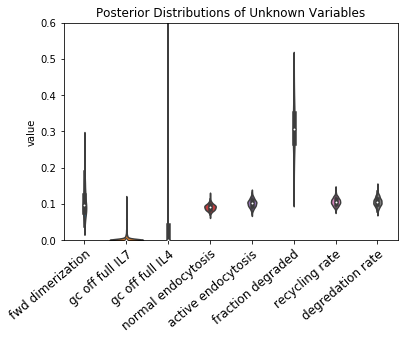

In [3]:
def violinPlots():
    """ Create violin plots of model posterior. """
    unkVec2 = unkVec.transpose()
    
    true_unknowns = np.array([unkVec2[:, 6], unkVec2[:, 13], unkVec2[:, 15], unkVec2[:, 17], unkVec2[:, 18], unkVec2[:, 19], unkVec2[:, 20], unkVec2[:, 21]])
    true_unknowns = true_unknowns.transpose()
    true_unknowns = pd.DataFrame(true_unknowns)
    
    true_unknowns.columns = ['fwd dimerization', 'gc off full IL7', 'gc off full IL4', 'normal endocytosis', 'active endocytosis', 'fraction degraded', 'recycling rate', 'degredation rate']
    a = sns.violinplot(data=true_unknowns)  # creates names based on dataframe columns
    a.set_xticklabels(a.get_xticklabels(),
                       rotation=40,
                       rotation_mode="anchor",
                       ha="right",
                       fontsize=12)
    a.set(ylabel='value', title='Posterior Distributions of Unknown Variables', ylim=(0, 0.6))

    
violinPlots()

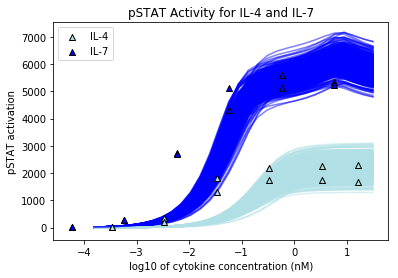

In [4]:
def pstat_plot():
    ''' This function calls the pstat_calc function to re-generate Gonnord figures S3B and S3C with our own fitting data. '''
    PTS = 30
    cytokC_4 = np.array([5., 50., 500., 5000., 50000., 250000.]) / 14900. # 14.9 kDa according to sigma aldrich
    cytokC_7 = np.array([1., 10., 100., 1000., 10000., 100000.]) / 17400. # 17.4 kDa according to prospec bio
    cytokC_common = np.logspace(-3.8, 1.5, num=PTS)
    dataIL4, dataIL7, data_pretreat = data_path()
    
    def plot_structure(IL4vec, IL7vec, title):
        plt.title(title)
        plt.plot(np.log10(cytokC_common), IL4vec, color='powderblue', alpha=0.5)
        plt.plot(np.log10(cytokC_common), IL7vec, color='b', alpha=0.5) 
        plt.ylabel('pSTAT activation' )
        plt.xlabel('log10 of cytokine concentration (nM)')

    for ii in range(0,500):
        output = pstat_calc(unkVec[:,ii], scales[ii,:], cytokC_common)
        IL4_output = output[0:PTS]
        IL7_output = output[PTS:(PTS*2)]

        plot_structure(IL4_output, IL7_output, "pSTAT Activity for IL-4 and IL-7")
        
    plt.scatter(np.log10(cytokC_4), dataIL4[:,1], color='powderblue', marker='^', edgecolors='k', zorder=100)
    plt.scatter(np.log10(cytokC_4), dataIL4[:,2], color='powderblue', marker='^', edgecolors='k', zorder=200, label='IL-4')
    plt.scatter(np.log10(cytokC_7), dataIL7[:,1], color='b', marker='^', edgecolors='k', zorder=300)
    plt.scatter(np.log10(cytokC_7), dataIL7[:,2], color='b', marker='^', edgecolors='k', zorder=400, label='IL-7')
    plt.legend()
    
pstat_plot()

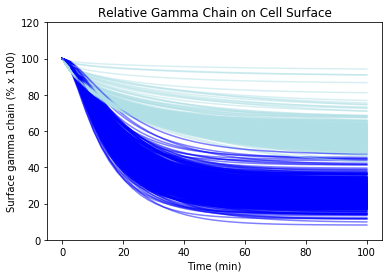

In [5]:
def surf_gc(cytokC_pg):
    size = 40
    ts = np.linspace(0., 100., num=size)
    output = calc_surf_gc(ts, cytokC_pg)
    IL4vec = output[:, 0:size]
    IL7vec = output[:, size:(size*2)]
    
    for ii in range(500):
        plt.plot(ts, IL4vec[ii, :], color='powderblue', alpha=0.5, zorder=ii)
        plt.plot(ts, IL7vec[ii, :], color='b', alpha=0.5, zorder=ii)
    
    plt.title("Relative Gamma Chain on Cell Surface")
    plt.ylim(0,120)
    plt.ylabel("Surface gamma chain (% x 100)")
    plt.xlabel("Time (min)")
    
surf_gc(1000.) 

In [6]:
from sklearn.metrics import r2_score

In [7]:
def calc_R2X_pstat():
    cytokC_4 = np.array([5., 50., 500., 5000., 50000., 250000.]) / 14900. # 14.9 kDa according to sigma aldrich
    cytokC_7 = np.array([1., 10., 100., 1000., 10000., 100000.]) / 17400. # 17.4 kDa according to prospec bio
    dataIL4, dataIL7, data_pretreat = data_path()
    dataIL4 = np.mean((dataIL4[:,1], dataIL4[:,2]), axis=0)
    dataIL4 = zscore(dataIL4)
    dataIL7 = np.mean((dataIL7[:,1], dataIL7[:,2]), axis=0)
    dataIL7 = zscore(dataIL7)
    R2X_4 = np.zeros((500))
    R2X_7 = R2X_4.copy()
    for ii in range(0,500):
        IL4_output = pstat_calc(unkVec[:,ii], scales[ii,:], cytokC_4)
        IL4_output = IL4_output[0:6]
        IL4_output = zscore(IL4_output)
        R2X_4[ii] = r2_score(IL4_output, dataIL4)
        IL7_output = pstat_calc(unkVec[:,ii], scales[ii,:], cytokC_7)
        IL7_output = IL7_output[6:(6*2)]
        IL7_output = zscore(IL7_output)
        R2X_7[ii] = r2_score(IL7_output, dataIL7)
        
    final_R2X_4 = np.mean(R2X_4)
    final_R2X_4 = round(final_R2X_4, 3)
    print("final R2X of pSTAT IL4 data is " + str(final_R2X_4))
    final_R2X_7 = np.mean(R2X_7)
    final_R2X_7 = round(final_R2X_7, 3)
    print("final R2X of pSTAT IL7 data is " + str(final_R2X_7))

In [8]:
calc_R2X_pstat()

final R2X of pSTAT IL4 data is 0.701
final R2X of pSTAT IL7 data is 0.837


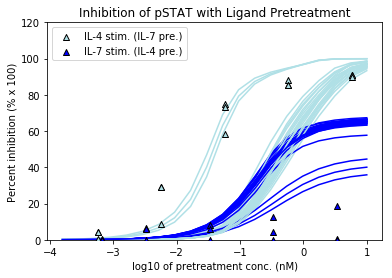

In [9]:
def plot_pretreat():
    unkVec, scales = import_samples()
    dataIL4, dataIL7, data_pretreat = data_path()
    IL7_pretreat_conc = data_pretreat[:, 0] / 17400. # concentrations used for IL7 pretreatment followed by IL4 stimulation
    IL4_pretreat_conc = data_pretreat[:, 5] / 14900. # concentrations used for IL4 pretreatment followed by IL7 stimulation 
    num = 20
    pre_IL4 = np.logspace(-3.8, 1.0, num=num)
    pre_IL7 = np.logspace(-3.8, 1.0, num=num)
    for ii in range(25):
        output = pretreat_calc(unkVec[:, ii], pre_IL4, pre_IL7)
        IL4_stim = output[0:num]
        IL7_stim = output[num:(num*2)]
        plt.plot(np.log10(pre_IL7), IL4_stim, color='powderblue', zorder=ii)
        plt.plot(np.log10(pre_IL4), IL7_stim, color='b', zorder=ii)
    
    plt.title('Inhibition of pSTAT with Ligand Pretreatment')
    plt.ylim(0,120)
    plt.ylabel("Percent inhibition (% x 100)")
    plt.xlabel("log10 of pretreatment conc. (nM)")
    
    # add experimental data to plots
    plt.scatter(np.log10(IL7_pretreat_conc), data_pretreat[:, 1], color='powderblue', zorder=100, marker='^', edgecolors='k', 
              label='IL-4 stim. (IL-7 pre.)')
    plt.scatter(np.log10(IL7_pretreat_conc), data_pretreat[:, 2], color='powderblue', zorder=101, marker='^', edgecolors='k')
    plt.scatter(np.log10(IL7_pretreat_conc), data_pretreat[:, 3], color='powderblue', zorder=102, marker='^', edgecolors='k')
    plt.scatter(np.log10(IL4_pretreat_conc), data_pretreat[:, 6], color='b', zorder=103, marker='^', edgecolors='k', 
              label='IL-7 stim. (IL-4 pre.)')
    plt.scatter(np.log10(IL4_pretreat_conc), data_pretreat[:, 7], color='b', zorder=104, marker='^', edgecolors='k')
    plt.scatter(np.log10(IL4_pretreat_conc), data_pretreat[:, 8], color='b', zorder=105, marker='^', edgecolors='k')
    plt.legend()
    
plot_pretreat()

In [10]:
def calc_R2X_pretreat():
    dataIL4, dataIL7, data_pretreat = data_path()
    IL7_pre = data_pretreat[:, 0] / 17400.
    IL4_stim_data = np.mean((data_pretreat[:,1], data_pretreat[:,2], data_pretreat[:,3]), axis=0)
    IL4_stim_data = zscore(IL4_stim_data)
    IL4_pre = data_pretreat[:, 5] / 14900.
    num = IL4_pre.size
    IL7_stim_data = np.mean((data_pretreat[:,6], data_pretreat[:,7], data_pretreat[:,8]), axis=0)
    IL7_stim_data = zscore(IL7_stim_data)
    R2X_4stim = np.zeros((500))
    R2X_7stim = R2X_4stim.copy()
    for ii in range(0,500):
        output = pretreat_calc(unkVec[:, ii], IL4_pre, IL7_pre)
        IL4_stim_output = output[0:num]
        IL4_stim_output = zscore(IL4_stim_output)
        IL7_stim_output = output[num:(num*2)]
        IL7_stim_output = zscore(IL7_stim_output)
        R2X_4stim[ii] = r2_score(IL4_stim_output, IL4_stim_data)
        R2X_7stim[ii] = r2_score(IL7_stim_output, IL7_stim_data)
        
    final_R2X_4stim = np.mean(R2X_4stim)
    final_R2X_4stim = round(final_R2X_4stim, 3)
    print("final R2X of pSTAT IL4 data under IL7 pretreatment is " + str(final_R2X_4stim))
    final_R2X_7stim = np.mean(R2X_7stim)
    final_R2X_7stim = round(final_R2X_7stim, 3)
    print("final R2X of pSTAT IL7 data under IL4 pretreatment is " + str(final_R2X_7stim))
    
calc_R2X_pretreat()

final R2X of pSTAT IL4 data under IL7 pretreatment is 0.608
final R2X of pSTAT IL7 data under IL4 pretreatment is 0.448
